In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
#!pip install np_utils

# Step 1 : importing Essential Libraries

In [ ]:
import os

%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(11) # It's my lucky number
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
import itertools

import keras
from keras.utils import to_categorical # used for converting labels to one-hot-encoding

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K


from keras.optimizers import Adam, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

from keras.applications.resnet50 import ResNet50
from keras import backend as K


# Step 2 : Loading pictures and making Dictionary of images and labels
In this step I load in the pictures and turn them into numpy arrays using their RGB values. As the pictures have already been resized to 224x224, there's no need to resize them. As the pictures do not have any labels, these need to be created. Finally, the pictures are added together to a big training set and shuffeled.

In [ ]:
folder_benign_train = '/content/drive/MyDrive/data/train/benign'
folder_malignant_train = '/content/drive/MyDrive/data/train/malignant'

folder_benign_test = '/content/drive/MyDrive/data/test/benign'
folder_malignant_test = '/content/drive/MyDrive/data/test/malignant'

read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))

# Load in training pictures
ims_benign = [read(os.path.join(folder_benign_train, filename)) for filename in os.listdir(folder_benign_train)]
X_benign = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join(folder_malignant_train, filename)) for filename in os.listdir(folder_malignant_train)]
X_malignant = np.array(ims_malignant, dtype='uint8')

# Load in testing pictures
ims_benign = [read(os.path.join(folder_benign_test, filename)) for filename in os.listdir(folder_benign_test)]
X_benign_test = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join(folder_malignant_test, filename)) for filename in os.listdir(folder_malignant_test)]
X_malignant_test = np.array(ims_malignant, dtype='uint8')

# Create labels
y_benign = np.zeros(X_benign.shape[0])
y_malignant = np.ones(X_malignant.shape[0])

y_benign_test = np.zeros(X_benign_test.shape[0])
y_malignant_test = np.ones(X_malignant_test.shape[0])


# Merge data
X_train = np.concatenate((X_benign, X_malignant), axis = 0)
print(len(X_train))
y_train = np.concatenate((y_benign, y_malignant), axis = 0)
print(len(y_train))

X_test = np.concatenate((X_benign_test, X_malignant_test), axis = 0)
print(len(X_test))
y_test = np.concatenate((y_benign_test, y_malignant_test), axis = 0)
print(len(y_test))
# Shuffle data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
y_train = y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
y_test = y_test[s]

520
520
60
60


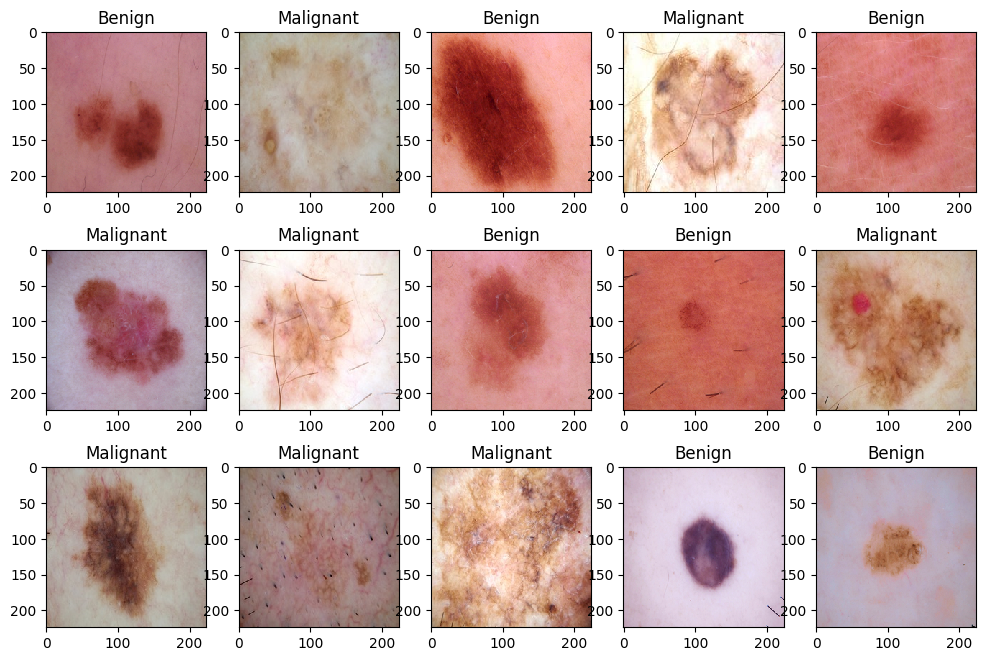

In [ ]:
# Display first 15 images of moles, and how they are classified
w=40
h=30
fig=plt.figure(figsize=(12, 8))
columns = 5
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if y_train[i] == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(X_train[i], interpolation='nearest')
plt.show()

# Step 3: Categorical Labels
Turn labels into one hot encoding

In [ ]:
y_train = to_categorical(y_train, num_classes= 2)

y_test = to_categorical(y_test, num_classes= 2)

# Step 4 : Normalization
Normalize all Values of the pictures by dividing all the RGB values by 255

In [ ]:
# With data augmentation to prevent overfitting
X_train = X_train/255.
X_test = X_test/255.

In [ ]:
# See learning curve and validation curve

def build(input_shape= (224,224,3), learning_rate = 1e-3, num_classes= 2,
          init= 'normal', activ= 'relu', optim= 'adam'):
    model = Sequential()
    model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',input_shape=input_shape,
                     activation= activ, kernel_initializer='glorot_uniform'))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',
                     activation =activ, kernel_initializer = 'glorot_uniform'))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer=init))
    model.add(Dense(num_classes, activation='softmax'))
    model.summary()

    if optim == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate)

    else:
        optimizer = Adam(learning_rate=learning_rate)

    model.compile(optimizer = optimizer ,loss = "binary_crossentropy", metrics=["accuracy"])
    return model

# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',

                                            patience=5,

                                            verbose=1,
                                            factor=0.5,
                                            min_lr=1e-7)



In [ ]:
input_shape = (224,224,3)
lr = 1e-5
init = 'normal'
activ = 'relu'
optim = 'adam'
epochs = 7
batch_size = 70

model = build(learning_rate=lr, init= init, activ= activ, optim=optim, input_shape= input_shape)
print(len(X_train))
print("*******************************\n")
print(len(y_train))

history = model.fit(X_train, y_train, validation_split=0.3,
                    epochs= epochs, batch_size= batch_size, verbose=1,
                    callbacks=[learning_rate_reduction]
                   )



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 64)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 112, 112, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 56, 56, 64)        0

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


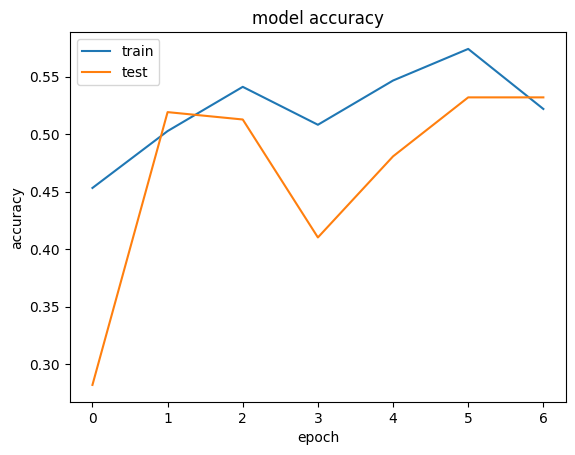

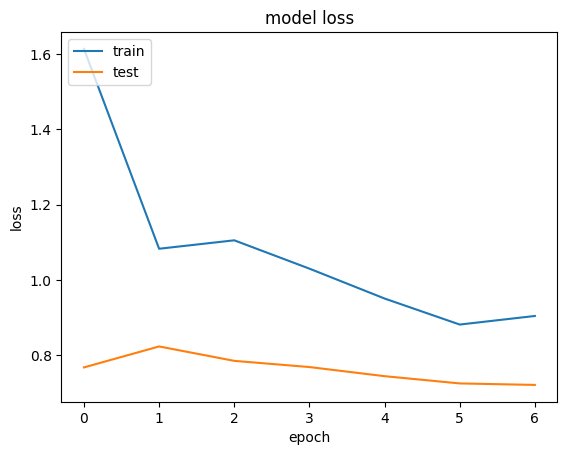

In [ ]:
# list all data in history
print(history.history.keys())
#dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
K.clear_session()
del model
del history

# Step 6: Cross-Validating Model


In [ ]:
# define 3-fold cross validation test harness
kfold = KFold(n_splits=3, shuffle=True, random_state=11)

cvscores = []
for train, test in kfold.split(X_train, y_train):
  # create model
    model = build(learning_rate=lr,
                  init= init,
                  activ= activ,
                  optim=optim,
                  input_shape= input_shape)

    # Fit the model
    model.fit(X_train[train], y_train[train], epochs=epochs, batch_size=batch_size, verbose=1)
    # evaluate the model
    scores = model.evaluate(X_train[test], y_train[test], verbose=1)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
    K.clear_session()
    del model

print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 64)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 112, 112, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 56, 56, 64)        0

# Step 7: Testing the model

First the model has to be fitted with all the data, such that no data is left out.

In [ ]:
# Fitting model to all data
model = build(learning_rate=lr,
              init= init,
              activ= activ,
              optim=optim,
              input_shape= input_shape)

model.fit(X_train, y_train,
          epochs=epochs, batch_size= epochs, verbose=1,
          callbacks=[learning_rate_reduction]
         )

# Testing model on test data to evaluate
y_pred = model.predict(X_test)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 64)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 112, 112, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 56, 56, 64)        0

75/75 [==============================] - 123s 2s/step - loss: 1.1054 - accuracy: 0.5250 - lr: 1.0000e-05
Epoch 2/7
75/75 [==============================] - ETA: 0s - loss: 0.9179 - accuracy: 0.5558

75/75 [==============================] - 128s 2s/step - loss: 0.9179 - accuracy: 0.5558 - lr: 1.0000e-05
Epoch 3/7
75/75 [==============================] - ETA: 0s - loss: 0.8309 - accuracy: 0.6365

75/75 [==============================] - 124s 2s/step - loss: 0.8309 - accuracy: 0.6365 - lr: 1.0000e-05
Epoch 4/7
75/75 [==============================] - ETA: 0s - loss: 0.7208 - accuracy: 0.6769

75/75 [==============================] - 132s 2s/step - loss: 0.7208 - accuracy: 0.6769 - lr: 1.0000e-05
Epoch 5/7
75/75 [==============================] - ETA: 0s - loss: 0.6526 - accuracy: 0.6827

75/75 [==============================] - 118s 2s/step - loss: 0.6526 - accuracy: 0.6827 - lr: 1.0000e-05
Epoch 6/7
75/75 [==============================] - ETA: 0s - loss: 0.6151 - accuracy: 0.7269

75/75 [==============================] - 120s 2s/step - loss: 0.6151 - accuracy: 0.7269 - lr: 1.0000e-05
Epoch 7/7
75/75 [==============================] - ETA: 0s - loss: 0.5815 - accuracy: 0.7231

2/2 [==============================] - 4s 2s/step


In [ ]:
print(y_test.dtype)
print(y_pred.dtype)

float32
float32


In [ ]:
y_test = y_test.astype(int)
print(y_test)



[[1 0]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [0 1]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [0 1]
 [0 1]]


In [ ]:
print(type(y_pred))
#y_pred = y_pred.reshape((3,2))

<class 'numpy.ndarray'>


In [ ]:
#print(accuracy_score(y_test, y_pred))
print(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))

0.7666666666666667
